## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [14]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

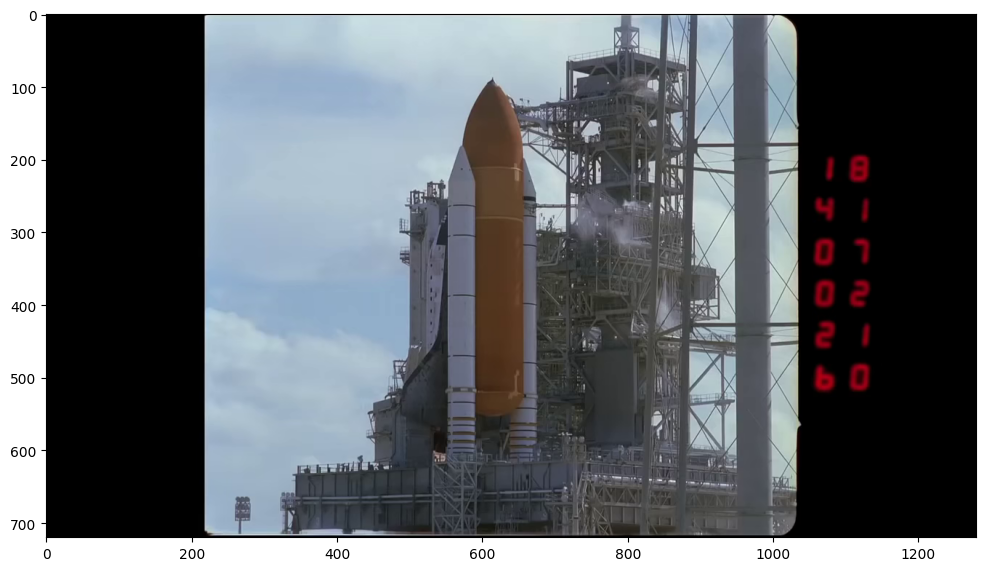

In [15]:
source = cv2.VideoCapture('dane/shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

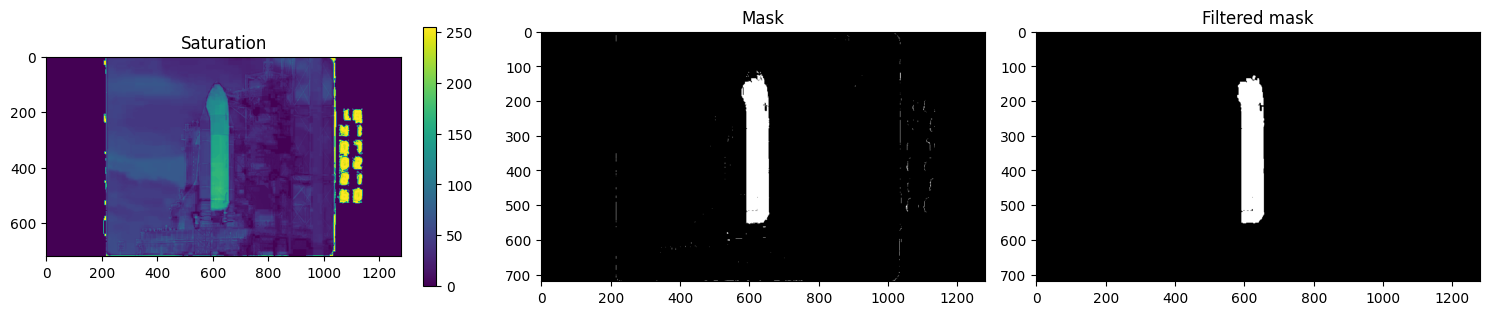

In [16]:
h,s,v = cv2.split(cv2.cvtColor(frame, cv2.COLOR_BGR2HSV))
mask = (s > 100) & (s < 180)
erode = cv2.erode(mask.astype(np.uint8), np.ones((5,5)))
dilate = cv2.dilate(erode, np.ones((5,5)))

plt.figure(figsize=(15,3))
plt.subplot(1, 3, 1)
im = plt.imshow(s)
plt.colorbar(im)
plt.title("Saturation")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.subplot(1, 3, 3)
plt.imshow(dilate, cmap='gray')
plt.title("Filtered mask")
plt.tight_layout()
plt.show()

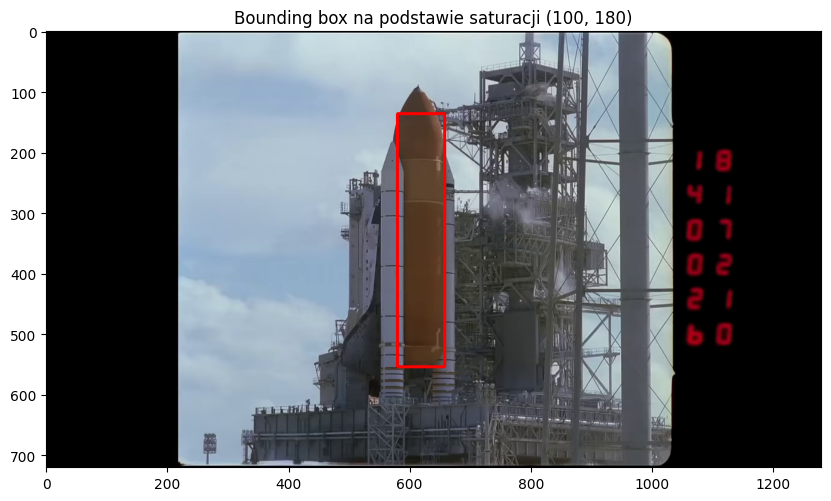

In [17]:
contours = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
x, y, w, h = cv2.boundingRect(contours[0])
cv2.rectangle(frame, (x, y), (w+x,h+y), (0,0,255), 4)
plt.figure(figsize=(10, 7))
plt.imshow(frame[..., ::-1])
plt.title("Bounding box na podstawie saturacji (100, 180)")
plt.show()

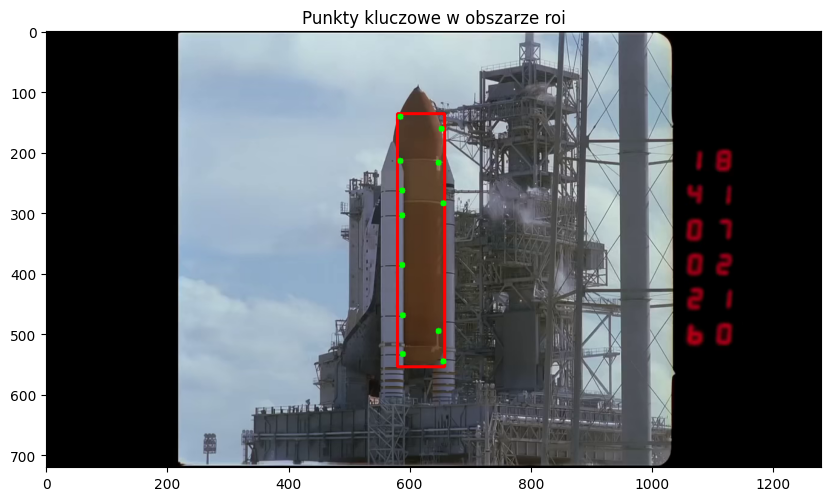

In [18]:
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
roi = gray_frame[y:y + h, x:x + w]

corners = cv2.goodFeaturesToTrack(
    roi,
    maxCorners=50,
    qualityLevel=0.01,
    minDistance=30,
    blockSize=7
)

# Transformacja współrzędnych do układu globalnego
output_frame = frame.copy()
if corners is not None:
    for corner in corners:
        cx, cy = corner.ravel()
        cx_global, cy_global = int(cx + x), int(cy + y)
        cv2.circle(output_frame, (cx_global, cy_global), radius=5, color=(0, 255, 0), thickness=-1)


plt.figure(figsize=(10, 7))
plt.title("Punkty kluczowe w obszarze roi")
plt.imshow(output_frame[..., ::-1])
plt.show()

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [19]:
def baseLoop(source: cv2.VideoCapture, png_path, start_frame, end_frame):

    source.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    status, frame2 = source.read()
    if not status:
        print("Nie można odczytać pierwszej klatki.")
        return

    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    roi = cv2.selectROI("Select ROI", frame2, fromCenter=False, showCrosshair=True)
    x, y, w, h = map(int, roi)
    roi_gray = frame2_gray[y:y + h, x:x + w]

    points = cv2.goodFeaturesToTrack(
        roi_gray,
        maxCorners=50,
        qualityLevel=0.01,
        minDistance=30,
        blockSize=7
    )

    if points is not None:
        points = points.reshape(-1, 2)
        points += [x, y]  # Przesunięcie punktów względem globalnych współrzędnych
        points = points.reshape(-1, 1, 2).astype(np.float32)
    else:
        print("Nie znaleziono punktów kluczowych.")
        return

    trajectories = [[] for _ in range(len(points))]

    frame_count = start_frame 
    while frame_count <= end_frame:

        # Aktualizacja klatek
        frame1_gray = frame2_gray
        status, frame2 = source.read()
        if not status:
            break
        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        next_points, status, _ = cv2.calcOpticalFlowPyrLK(
            frame1_gray, frame2_gray, points, None,
            winSize=(15, 15),
            maxLevel=3,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
        )

        # Filtracja punktów, które stracono podczas śledzenia
        valid_points = next_points[status.flatten() == 1]
        valid_status = status.flatten()

        new_trajectories = []
        for i, (point, valid) in enumerate(zip(next_points, valid_status)):
            if valid:
                trajectories[i].append((int(point[0][0]), int(point[0][1])))
                new_trajectories.append(trajectories[i])

        points = valid_points.reshape(-1, 1, 2)
        trajectories = new_trajectories

        # Wizualizacja trajektorii w czasie
        output_frame = frame2.copy()
        for trajectory in trajectories:
            for i in range(1, len(trajectory)):
                pt1 = trajectory[i - 1]
                pt2 = trajectory[i]
                cv2.line(output_frame, pt1, pt2, (0, 255, 0), 2)

        cv2.imshow("Trajektorie śledzonych punktów", output_frame)


        if cv2.waitKey(1) & 0xFF == 10:
            break

        frame_count += 1

    cv2.imwrite(png_path, output_frame)

    source.release()
    cv2.destroyAllWindows()

    return trajectories

In [21]:
png_path = "last_frame_with_trajectories.png"
source = cv2.VideoCapture("dane/shuttle.mp4")
trajectories = baseLoop(source, png_path, start_frame=0, end_frame=270)

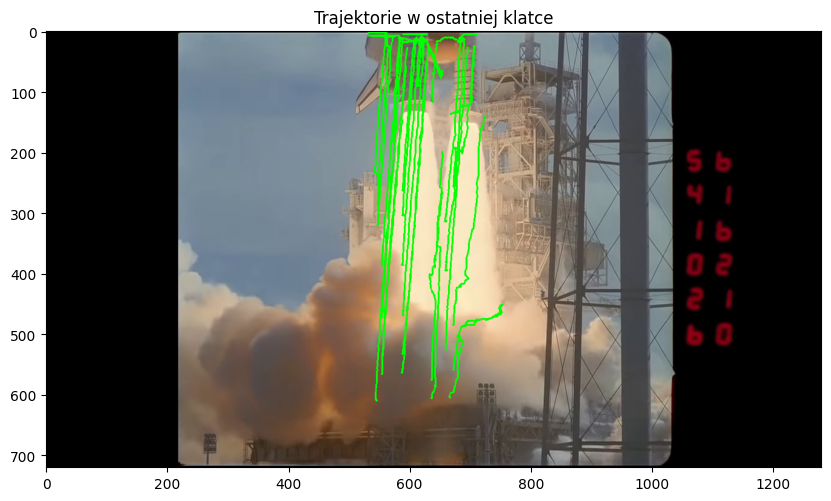

In [8]:
image = cv2.imread(png_path)
plt.figure(figsize=(10, 7))
plt.imshow(image[..., ::-1])
plt.title("Trajektorie w ostatniej klatce")
plt.show()

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.

https://www.nasa.gov/reference/the-space-shuttle/ \
Długość rakiety 56m

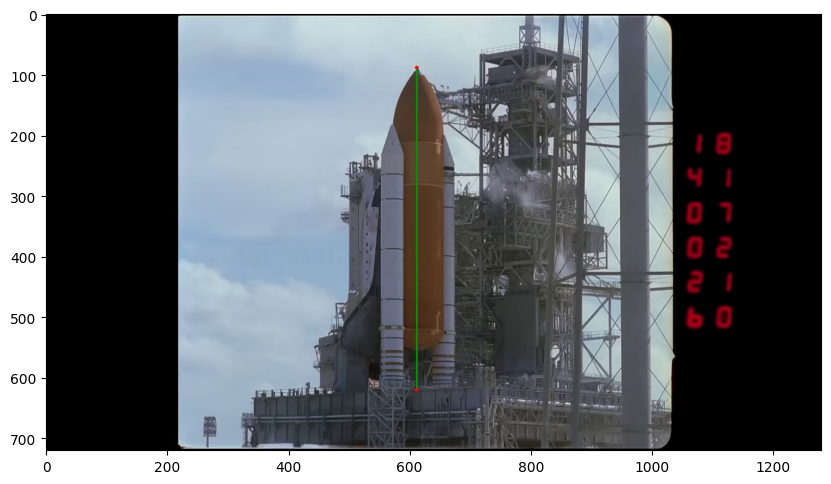

In [9]:
source = cv2.VideoCapture('dane/shuttle.mp4')
status, frame = source.read()
source.release()
frame_copy = frame.copy()
plt.figure(figsize=(10, 10))
cv2.line(frame_copy, (612, 88), (612, 620), (0, 150, 0), 2)
cv2.circle(frame_copy, (612, 88), 3, (0, 0, 255), -1)
cv2.circle(frame_copy, (612, 620), 3, (0, 0, 255), -1)
plt.imshow(frame_copy[..., ::-1])

In [10]:
def calculate_velocity_per_trajectory(trajectories, fps, pixel_to_meter_ratio):
    velocity_data = []
    
    for trajectory in trajectories:
        if len(trajectory) < 2:
            continue
        trajectory_meters = [(x * pixel_to_meter_ratio, y * pixel_to_meter_ratio) for x, y in trajectory]

        times = []
        velocities = []
        for i in range(1, len(trajectory_meters)):
            x1, y1 = trajectory_meters[i - 1]
            x2, y2 = trajectory_meters[i]
            distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            velocity = distance * fps
            velocities.append(velocity)
            times.append(i / fps)
        
        velocity_data.append({'times': times, 'velocities': velocities})
    
    return velocity_data

In [11]:
cap = cv2.VideoCapture('dane/shuttle.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)

rocket_hight_px = 618 - 88
rocket_hight_m = 56
scale = rocket_hight_m / rocket_hight_px

velocity_data  = calculate_velocity_per_trajectory(trajectories, fps, scale)

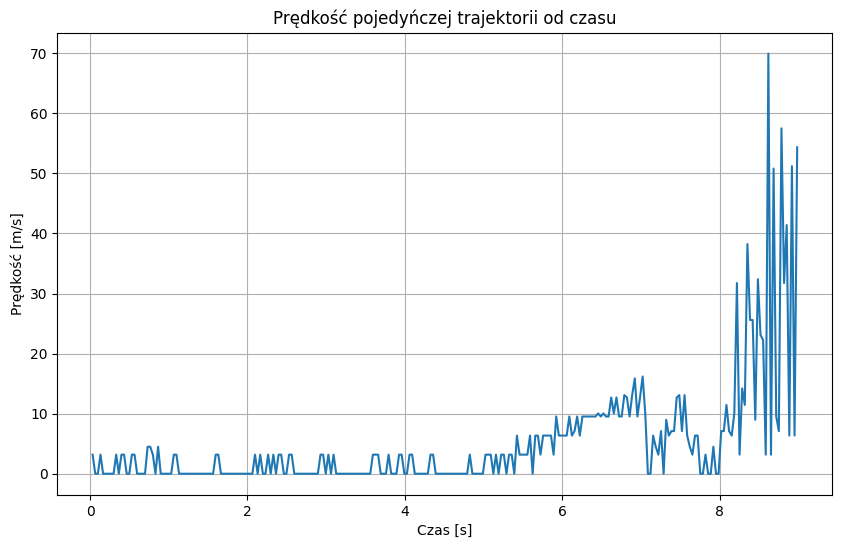

In [12]:
selected_trajectory = velocity_data[-1]
plt.figure(figsize=(10, 6))
plt.plot(selected_trajectory['times'], selected_trajectory['velocities'])
plt.title(f"Prędkość pojedyńczej trajektorii od czasu")
plt.xlabel("Czas [s]")
plt.ylabel("Prędkość [m/s]")
plt.grid(True)
plt.show()

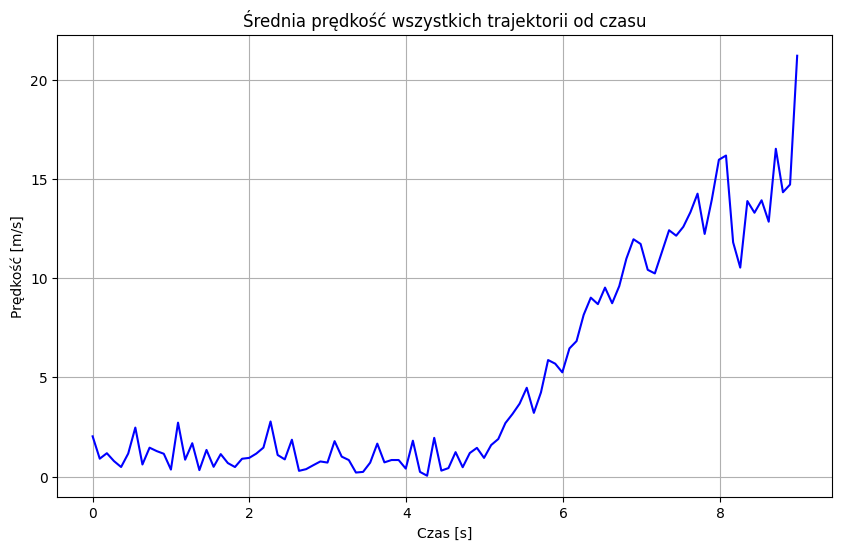

In [13]:
all_times = []
all_velocities = []
for trajectory in velocity_data:
    all_times.append(trajectory['times'])
    all_velocities.append(trajectory['velocities'])

# Wyznacz wspólną siatkę czasową
max_time = max([times[-1] for times in all_times if len(times) > 0])
time_grid = np.linspace(0, max_time, num=100)

# Interpolacja prędkości na wspólną siatkę czasową
interpolated_velocities = []
for times, velocities in zip(all_times, all_velocities):
    if len(times) > 0:
        interp_vel = np.interp(time_grid, times, velocities)
        interpolated_velocities.append(interp_vel)

interpolated_velocities = np.array(interpolated_velocities)
avg_velocities = np.mean(interpolated_velocities, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(time_grid, avg_velocities, color="blue")
plt.title("Średnia prędkość wszystkich trajektorii od czasu")
plt.xlabel("Czas [s]")
plt.ylabel("Prędkość [m/s]")
plt.grid(True)
plt.show()